In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
retail = pd.read_csv('/kaggle/input/online-retail-data/retail.csv')
retail

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [3]:
print('The size of Dataframe is: ', retail.shape)
print('-'*100)
print('The Column Name, Record Count and Data Types are as follows: ')
retail.info()
print('-'*100)

The size of Dataframe is:  (1067371, 8)
----------------------------------------------------------------------------------------------------
The Column Name, Record Count and Data Types are as follows: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
----------------------------------------------------------------------------------------------------


In [4]:
# Defining numerical & categorical columns
numeric_features = [feature for feature in retail.columns if retail[feature].dtype != 'O']
categorical_features = [feature for feature in retail.columns if retail[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 3 numerical features : ['Quantity', 'Price', 'Customer ID']

We have 5 categorical features : ['Invoice', 'StockCode', 'Description', 'InvoiceDate', 'Country']


### Data Description

- **Invoice:** Invoice number. A unique number for each transaction. If it starts with C which means cancelled operations.

- **StockCode:** Product code. A unique number for each product.

- **Description:** Product name.

- **Quantity:** It refers to how many of the products in the invoices have been sold.

- **InvoiceDate:** Invoice date.

- **Price:** Product price (pound)

- **Customer ID:** Unique customer number.

- **Country:** The name of the country where the customer lives.

In [5]:
print('Missing Value Presence in different columns of DataFrame are as follows : ')
print('-'*100)
total=retail.isnull().sum().sort_values(ascending=False)
percent=(retail.isnull().sum()/retail.isnull().count()*100).sort_values(ascending=False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

Missing Value Presence in different columns of DataFrame are as follows : 
----------------------------------------------------------------------------------------------------


,Total,Percent
Customer ID,243007,22.766873
Description,4382,0.410541
Invoice,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Country,0,0.000000


In [6]:
print('Summary Statistics of numerical features for DataFrame are as follows:')
print('-'*100)
retail.describe()

Summary Statistics of numerical features for DataFrame are as follows:
----------------------------------------------------------------------------------------------------


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [7]:
print('Summary Statistics of categorical features for DataFrame are as follows:')
print('-'*100)
retail.describe(include= 'object')

Summary Statistics of categorical features for DataFrame are as follows:
----------------------------------------------------------------------------------------------------


,Invoice,StockCode,Description,InvoiceDate,Country
count,1067371,1067371,1062989,1067371,1067371
unique,53628,5305,5698,47635,43
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-06 16:57:00,United Kingdom
freq,1350,5829,5918,1350,981330


In [8]:
print('-'*125)
print('Checking records for mis-spell, typo-error etc.')
print('-'*125)

print("'Invoice' variable have {} unique category : \n{}\n".format(retail['Invoice'].nunique(), retail['Invoice'].unique()))
print('-'*125)

print("'StockCode' variable have {} unique category : \n{}\n".format(retail['StockCode'].nunique(), retail['StockCode'].unique()))
print('-'*125)

print("'Description' variable have {} unique category : \n{}\n".format(retail['Description'].nunique(), retail['Description'].unique()))
print('-'*125)

print("'Country' variable have {} unique category : \n{}\n".format(retail['Country'].nunique(), retail['Country'].unique()))
print('-'*125)

-----------------------------------------------------------------------------------------------------------------------------
Checking records for mis-spell, typo-error etc.
-----------------------------------------------------------------------------------------------------------------------------
'Invoice' variable have 53628 unique category : 
['489434' '489435' '489436' ... '581585' '581586' '581587']

-----------------------------------------------------------------------------------------------------------------------------
'StockCode' variable have 5305 unique category : 
['85048' '79323P' '79323W' ... '23609' '23617' '23843']

-----------------------------------------------------------------------------------------------------------------------------
'Description' variable have 5698 unique category : 
['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... 'mixed up'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']

----------

### Missing Value Treatment

In [9]:
print('Missing Value Presence in different columns of DataFrame are as follows : ')
print('-'*100)
total=retail.isnull().sum().sort_values(ascending=False)
percent=(retail.isnull().sum()/retail.isnull().count()*100).sort_values(ascending=False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

Missing Value Presence in different columns of DataFrame are as follows : 
----------------------------------------------------------------------------------------------------


,Total,Percent
Customer ID,243007,22.766873
Description,4382,0.410541
Invoice,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Country,0,0.000000


- **22.76%** of Customer ID is missing. Drop the columns as primary information Customer ID is missing.

#### Dropping empty Customer ID

In [10]:
retail = retail.dropna()
retail.shape

(824364, 8)

### Datatype Conversion

Changing DataType of Customer ID as per Business requirement

In [11]:
retail['Customer ID'] = retail['Customer ID'].astype(str)

In [12]:
retail.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID     object
Country         object
dtype: object

### Removing invalid entries from columns

Price and Quantity must be positive values i.e. greater than 0)

In [13]:
(retail['Price']<=0).value_counts()

Price
False    824293
True         71
Name: count, dtype: int64

- There exists **invalid values** for Price column. **71 row entries** are less than or equal to 0**

In [14]:
retail.shape

(824364, 8)

In [15]:
retail = retail[retail['Price']>0]

In [16]:
retail.shape

(824293, 8)

In [17]:
(retail['Quantity']<=0).value_counts()

Quantity
False    805549
True      18744
Name: count, dtype: int64

There exists **invalid values** for Quantity column. **18744 row entries** are negative (less than 0). We need to drop these rows**

In [18]:
retail.shape

(824293, 8)

In [19]:
retail = retail[retail['Quantity']>=0]

In [20]:
retail.shape

(805549, 8)

In [21]:
retail

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


## 6) RFM Metrics &  Scores Calculation
---

### RFM Attribute Creation(Feature Engineering)

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

#### New Attribute Creation: Monetary

In [22]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['Price']
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [23]:
rfm_m = retail.groupby('Customer ID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['Customer ID', 'Monetary']
rfm_m.head()

,Customer ID,Monetary
0,12346.0,77556.46
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4428.69
4,12350.0,334.40


#### New Attribute Creation: Frequency

In [24]:
# New Attribute : Frequency

rfm_f = retail.groupby('Customer ID')['Invoice'].count()
rfm_f = rfm_f.reset_index()
rfm_f.head()

,Customer ID,Invoice
0,12346.0,34
1,12347.0,253
2,12348.0,51
3,12349.0,175
4,12350.0,17


In [25]:
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head()

,Customer ID,Frequency
0,12346.0,34
1,12347.0,253
2,12348.0,51
3,12349.0,175
4,12350.0,17


In [26]:
# Merging the newly created dataframes together

rfm = pd.merge(rfm_m, rfm_f, on='Customer ID', how='inner')
rfm.head()

,Customer ID,Monetary,Frequency
0,12346.0,77556.46,34
1,12347.0,5633.32,253
2,12348.0,2019.40,51
3,12349.0,4428.69,175
4,12350.0,334.40,17


#### New Attribute Creation: Recency

In [27]:
retail.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID     object
Country         object
Amount         float64
dtype: object

- InvoiceDate is not in datetime datatype. Here, need for DataType Conversion

In [28]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [29]:
retail.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
Amount                float64
dtype: object

In [30]:
# Getting Data range

min_date = min(retail['InvoiceDate'])
max_date = max(retail['InvoiceDate'])

print(min_date,max_date)

2009-12-01 07:45:00 2011-12-09 12:50:00


In [31]:
# Compute the difference between max date and transaction date

retail['Diff_Days'] = max_date - retail['InvoiceDate']
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,Diff_Days
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,738 days 05:05:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,738 days 05:05:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,738 days 05:05:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,738 days 05:05:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,738 days 05:05:00


In [32]:
# Compute last transaction date to get the recency of customers

rfm_r = retail.groupby('Customer ID')['Diff_Days'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,Customer ID,Diff_Days
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [33]:
# Extract number of days only

rfm_r['Diff_Days'] = rfm_r['Diff_Days'].dt.days
rfm_r.head()

,Customer ID,Diff_Days
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [34]:
# Merge all the newly created attribute to get the final RFM dataframe

rfm = pd.merge(rfm,rfm_r, on='Customer ID', how='inner')
rfm.columns = ['Customer ID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,Customer ID,Monetary,Frequency,Recency
0,12346.0,77556.46,34,325
1,12347.0,5633.32,253,1
2,12348.0,2019.40,51,74
3,12349.0,4428.69,175,18
4,12350.0,334.40,17,309


In [35]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Monetary,5878.0,3018.616737,14737.731040,2.95,348.7625,898.915,2307.09,608821.65
Frequency,5878.0,137.044743,353.818629,1.00,21.0000,53.000,142.00,12890.00
Recency,5878.0,200.331916,209.338707,0.00,25.0000,95.000,379.00,738.00


In [36]:
rfm.shape

(5878, 4)

**`Note:`** There are 5878 unique count of customers.

### Calculating RFM Scores using RFM Metrics

In [37]:
rfm_scores = rfm.copy()

In [38]:
rfm_scores.head()

,Customer ID,Monetary,Frequency,Recency
0,12346.0,77556.46,34,325
1,12347.0,5633.32,253,1
2,12348.0,2019.40,51,74
3,12349.0,4428.69,175,18
4,12350.0,334.40,17,309


For each RFM dimension, score can be calculated in several ways: 

- 1.Percentiles e.g. quantiles

- 2.Pareto 80/20 cut

- 3.Custom based on business knowledge

We are going to implement **percentile-based grouping** for each RFM dimension. Later combined label is created using these each RFM dimension.


### Process of calculating percentiles:

- Sort customers based on that metric
- Break customers into a pre-defined number of groups of equal size
- Assign a label to each group

### Individual RFM dimension label

For each RFM dimension, assign labels to the categories based on the behavior we want to capture. These labels should be intuitive and provide insight into customer behavior. Here's an example for each dimension:

   - **Recency (R):**
     - Label 5: "Very Recent"
     - Label 4: "Recent"
     - Label 3: "Moderate"
     - Label 2: "Infrequent"
     - Label 1: "Very Infrequent"

   - **Frequency (F):**
     - Label 5: "Very Frequent"
     - Label 4: "Frequent"
     - Label 3: "Moderate"
     - Label 2: "Infrequent"
     - Label 1: "Very Infrequent"

   - **Monetary (M):**
     - Label 5: "High Spending"
     - Label 4: "Above Average Spending"
     - Label 3: "Average Spending"
     - Label 2: "Below Average Spending"
     - Label 1: "Low Spending"

### Combined RFM Labels

Once we have assigned labels to the categories for each RFM dimension, you can create a **combined RFM label** for each customer by **concatenating the individual dimension labels** or by **adding individual dimension scores**. For example:
   
   - If a customer has **R=4, F=5, and M=3**, their combined RFM label would be **"Recent-Very Frequent-Average Spending."**


- We will rate **Recency** customer who have been active more recently better than the less recent customer,because each company wants its customers to be recent

- We will rate **Frequency** and **Monetary Value** higher label because we want Customer to spend more money and visit more often (that is different order than recency).

### Creating Individual RFM Dimension label

In [39]:
#Date from customer's last purchase.The nearest date gets 5 and the furthest date gets 1.
rfm_scores['Recency_Score'] = pd.qcut(rfm_scores['Recency'],5,labels=[5,4,3,2,1])
# Total number of purchases.The least frequency gets 1 and the maximum frequency gets 5.
rfm_scores['Frequency_Score'] = pd.qcut(rfm_scores['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
#Total spend by the customer.The least money gets 1, the most money gets 5.
rfm_scores['Monetary_Score'] = pd.qcut(rfm_scores['Monetary'],5,labels=[1,2,3,4,5])

In [40]:
rfm_scores.head()

,Customer ID,Monetary,Frequency,Recency,Recency_Score,Frequency_Score,Monetary_Score
0,12346.0,77556.46,34,325,2,2,5
1,12347.0,5633.32,253,1,5,5,5
2,12348.0,2019.40,51,74,3,3,4
3,12349.0,4428.69,175,18,5,4,5
4,12350.0,334.40,17,309,2,2,2


- **`Best Recency score = 5:` most recently purchase.** 
- **`Best Frequency score = 5:` most number of purchase.**
- **`Best Monetary score = 5:` spent the most.**

### Creating Combined RFM Label

#### Method-1:  By concatenating the individual dimension labels

In [41]:
rfm_scores['RFM_Score_Segment'] = (rfm_scores['Recency_Score'].astype(str)+rfm_scores['Frequency_Score'].astype(str)+rfm_scores['Monetary_Score'].astype(str))

In [42]:
rfm_scores.head()

,Customer ID,Monetary,Frequency,Recency,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score_Segment
0,12346.0,77556.46,34,325,2,2,5,225
1,12347.0,5633.32,253,1,5,5,5,555
2,12348.0,2019.40,51,74,3,3,4,334
3,12349.0,4428.69,175,18,5,4,5,545
4,12350.0,334.40,17,309,2,2,2,222


#### Method-2:  By adding individual dimension label scores

In [43]:
rfm_scores['RFM_Score_Sum'] = rfm_scores[['Recency_Score','Frequency_Score','Monetary_Score']].sum(axis=1)

In [44]:
rfm_scores.head()

,Customer ID,Monetary,Frequency,Recency,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score_Segment,RFM_Score_Sum
0,12346.0,77556.46,34,325,2,2,5,225,9
1,12347.0,5633.32,253,1,5,5,5,555,15
2,12348.0,2019.40,51,74,3,3,4,334,10
3,12349.0,4428.69,175,18,5,4,5,545,14
4,12350.0,334.40,17,309,2,2,2,222,6


### `Note:`
- Adding individual dimension score( eg. 5+1+1) will create a score  between 3 and 15. Here each of the scores got same importance whether its **413 & 431**. However both **413 & 431** represent different segment.

## 7) Segmenting Customers based on RFM Scores 
#### (Manual Approach - Without Model Building)
---

### Method-1: Interpeting Customer Segmentation using RFM_Score_Sum

In [45]:
rfm_scores.groupby(['RFM_Score_Sum']).agg({'Recency': 'mean',
                                           'Frequency': 'mean',
                                           'Monetary': ['mean', 'count']}).round(1)

Recency Frequency Monetary      
                 mean      mean     mean count
RFM_Score_Sum                                 
3               569.1       7.6    141.7   353
4               444.9      13.2    204.4   402
5               372.3      19.8    323.7   494
6               282.7      24.8    421.3   500
7               248.4      33.7    717.4   493
8               210.9      48.4    946.7   481
9               163.4      61.9   1427.8   514
10              136.2      82.3   1413.2   436
11               91.0     109.3   2507.6   486
12               69.6     170.3   2982.0   452
13               39.7     221.7   3927.4   427
14               23.8     351.6   7261.4   411
15                6.7     695.7  18306.8   429

#### Use RFM_Score_Sum to group customers into Gold, Silver and Bronze segments

In [46]:
def segments(df):
    if df['RFM_Score_Sum'] > 9 :
        return 'Gold'
    elif (df['RFM_Score_Sum'] > 5) and (df['RFM_Score_Sum'] <= 9 ):
        return 'Sliver'
    else:  
        return 'Bronze'

In [47]:
rfm_scores['Segment Name'] = rfm_scores.apply(segments,axis=1)

In [48]:
rfm_scores.head()

,Customer ID,Monetary,Frequency,Recency,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score_Segment,RFM_Score_Sum,Segment Name
0,12346.0,77556.46,34,325,2,2,5,225,9,Sliver
1,12347.0,5633.32,253,1,5,5,5,555,15,Gold
2,12348.0,2019.40,51,74,3,3,4,334,10,Gold
3,12349.0,4428.69,175,18,5,4,5,545,14,Gold
4,12350.0,334.40,17,309,2,2,2,222,6,Sliver


In [49]:
rfm_scores.groupby(['Segment Name']).agg({'Recency':'mean',
                                         'Frequency':'mean',
                                         'Monetary':['mean','count']}).round(1).sort_values(by=('Monetary','count'), 
                                                                                            ascending=False)

Recency Frequency Monetary      
                mean      mean     mean count
Segment Name                                 
Gold            62.3     266.4   5943.9  2641
Sliver         226.0      42.3    882.1  1988
Bronze         451.3      14.2    233.8  1249

#### Inference

- **Gold Customers:** 2643
- **Silver Customers:** 1992
- **Bronze Customers:** 1246

### Method-2: Interpeting Customer Segmentation using RFM_Score_Segment

### Based on Recency & Frequency Score
- **can't loose them →** A class of customers who used to shop very frequently but have not shopped for a long time and should not be lost.
- **at risk →** A class of customers who shop relatively frequently but have not shopped for a long time. 
- **hibernating →** Customers who are literally asleep, both shopped infrequently and have not shopped for a long time.
- **about to sleep →** A class of customers who do not shop frequently and have not shopped for some time; they are heading towards sleep.
- **need attention →** This is the class of customers in the middle of the RF graph (33%), moving towards the risky group if not addressed.
- **new customers →** A class of customers who have not shopped frequently (maybe once) and have been shopping for a short period of time, they are considered as new customers.
- **promising →** New customers are the aged version of new customers :) they are customers who have not shopped frequently and have shopped for a short period of time.
- **potential loyalists →** Customers who shop moderately often and it has not been long since their last purchase.
- **loyal customers →** Customers who shop very often and it has been a short time since their last purchase.
- **champions →** They are our champions, our crown jewels! Customers who shop very often and have made their last purchase within a very short period of time.

![image.png](https://raw.githubusercontent.com/manishkr1754/Online_Retail_Customer_Segmentation_RFM_Analysis/main/rfm_label.png)

In [50]:
# Display the top 10 segments with the most customers
rfm_scores.groupby(['RFM_Score_Segment']).size().sort_values(ascending=False)[:10]

RFM_Score_Segment
555    429
111    353
455    248
211    198
122    177
222    163
344    160
444    150
333    144
233    141
dtype: int64

#### Mapping Segment as per Recency and Frequency Score (Keeping Monetary Unchanged)

In [51]:
segment_mapping = {r'[1-2][1-2][1-5]': 'Hibernating',
                   r'[1-2][3-4][1-5]': 'At Risk',
                   r'[1-2][5][1-5]': 'Can\'t Loose',
                   r'[3][1-2][1-5]': 'About to Sleep',
                   r'[3][3][1-5]': 'Need Attention',
                   r'[3-4][4-5][1-5]': 'Loyal Customers',
                   r'[4][1][1-5]': 'Promising',
                   r'[5][1][1-5]': 'New Customers',
                   r'[4-5][2-3][1-5]': 'Potential Loyalists',
                   r'[5][4-5][1-5]': 'Champions'
                  }

In [52]:
rfm_scores['Segment'] = rfm_scores['RFM_Score_Segment'].replace(segment_mapping,regex=True)
#rfm_scores.reset_index(inplace=True)
rfm_scores.head()

,Customer ID,Monetary,Frequency,Recency,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score_Segment,RFM_Score_Sum,Segment Name,Segment
0,12346.0,77556.46,34,325,2,2,5,225,9,Sliver,Hibernating
1,12347.0,5633.32,253,1,5,5,5,555,15,Gold,Champions
2,12348.0,2019.40,51,74,3,3,4,334,10,Gold,Need Attention
3,12349.0,4428.69,175,18,5,4,5,545,14,Gold,Champions
4,12350.0,334.40,17,309,2,2,2,222,6,Sliver,Hibernating


In [53]:
rfm_scores.groupby(['Segment']).agg({"Customer ID":"count"}).sort_values("Customer ID",ascending=False)

,Customer ID
Segment,
Hibernating,1437
Loyal Customers,1135
Champions,821
At Risk,802
Potential Loyalists,676
About to Sleep,428
Need Attention,270
Promising,125
Can't Loose,108


In [54]:
rfm_scores[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count","max"]).round()

Recency            Frequency              Monetary        \
                       mean count  max      mean count    max     mean count   
Segment                                                                        
About to Sleep        109.0   428  188      18.0   428     37    670.0   428   
At Risk               394.0   802  737      74.0   802    178   1315.0   802   
Can't Loose           346.0   108  623     325.0   108   2796   4651.0   108   
Champions               8.0   821   18     449.0   821  12890  10934.0   821   
Hibernating           451.0  1437  738      16.0  1437     37    518.0  1437   
Loyal Customers        64.0  1135  188     234.0  1135   1874   4165.0  1135   
Need Attention        107.0   270  187      55.0   270     76   1403.0   270   
New Customers           9.0    76   18       9.0    76     16   2927.0    76   
Potential Loyalists    25.0   676   58      44.0   676     76   1184.0   676   
Promising              37.0   125   58       9.0   125     16    395.0   125   

                               
                          max  
Segment                        
About to Sleep        39916.0  
At Risk               67502.0  
Can't Loose           56600.0  
Champions            608822.0  
Hibernating           77556.0  
Loyal Customers      144458.0  
Need Attention        16246.0  
New Customers        168472.0  
Potential Loyalists   30393.0  
Promising              5120.0

#### Inference

- **About to Sleep:** 428
- **At Risk:** 802
- **Can't Loose:** 108
- **Champions:** 821
- **Hibernating:** 1439
- **Loyal Customers:** 1135
- **Need Attention:** 270
- **New Customers:** 77
- **Potential Loyalists:** 677
- **Promising:** 124

### Method-3: Interpeting Customer Segmentation using RFM_Score_Segment

### Based on all three RFM dimension (Recency, Frequency & Monetary)

**Below image shows the inverse scoring. We need to 1 against 5 and 5 against 1**
![image.jpg](https://raw.githubusercontent.com/manishkr1754/Online_Retail_Customer_Segmentation_RFM_Analysis/main/rfm_label_2.JPG)

#### Mapping Segment as per all three RFM dimension

In [55]:
segment_mapping = {r'[4-5][4-5][4-5]': 'Best Customers',
                   r'[1-5][4-5][1-5]': 'Loyal Customers',
                   r'[1-5][1-5][4-5]': 'Big Spenders',
                   r'[2-3][1-5][1-5]': 'Almost Lost',
                   r'[1][1-5][1-5]': 'Lost Customers',
                   r'[4-5][1-3][1-3]': 'Recent Active Low Spender',
                  }

In [56]:
rfm_scores['Segment_New'] = rfm_scores['RFM_Score_Segment'].replace(segment_mapping,regex=True)
#rfm_scores.reset_index(inplace=True)
rfm_scores.head()

,Customer ID,Monetary,Frequency,Recency,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score_Segment,RFM_Score_Sum,Segment Name,Segment,Segment_New
0,12346.0,77556.46,34,325,2,2,5,225,9,Sliver,Hibernating,Big Spenders
1,12347.0,5633.32,253,1,5,5,5,555,15,Gold,Champions,Best Customers
2,12348.0,2019.40,51,74,3,3,4,334,10,Gold,Need Attention,Big Spenders
3,12349.0,4428.69,175,18,5,4,5,545,14,Gold,Champions,Best Customers
4,12350.0,334.40,17,309,2,2,2,222,6,Sliver,Hibernating,Almost Lost


In [57]:
rfm_scores.groupby(['Segment_New']).agg({"Customer ID":"count"}).sort_values("Customer ID",ascending=False)

,Customer ID
Segment_New,
Almost Lost,1384
Best Customers,1273
Loyal Customers,1078
Lost Customers,990
Recent Active Low Spender,713
Big Spenders,440


#### Inference
	
- **Almost Lost:**	1397
- **Best Customers:**	1273
- **Loyal Customers:**	1079
- **Lost Customers:**	977
- **Recent Active Low Spender:**	714
- **Big Spenders:**	441

## K-Means Clustering
---
K-Means clustering is a popular **unsupervised machine learning algorithm** used for clustering data points into groups or clusters. In order to apply K-Means, we must check if the key assumptions of K-Means Clustering are followed.

### Key Assumptions of K-Means

1. **Symmetric Distribution of Variables (Not Skewed):** K-Means assumes that the variables have a **roughly symmetric distribution and are not heavily skewed**. This is because K-Means uses the mean (centroid) of data points within a cluster to define the cluster center. If the data is highly skewed with a long tail on one side, the mean may not be a representative measure of central tendency and K-Means may not perform well. In such cases, you may need to consider data transformation techniques to make the data more symmetric.

2. **Variables with Same Average Values:** K-Means assumes that the variables have **similar means**. If the variables have significantly different average values, it can lead to unequal contributions of variables to the distance calculation between data points which can impact the clustering results. **Standardizing or scaling** the variables (e.g. using z-score normalization) can help address this issue by giving all variables equal importance.

3. **Variables with Same Variance:** K-Means also assumes that the variables have **roughly equal variances**. Variables with different variances can disproportionately affect the distance calculations because K-Means uses the Euclidean distance metric which is sensitive to the scale of the variables. Again, standardizing or scaling the variables can help mitigate this problem.

### What if Assumptions are not followed
In practice, data rarely perfectly satisfies these assumptions and K-Means can still be applied with some caution. However, when these assumptions are strongly violated, itx is advisable to consider **alternative clustering algorithms** or **preprocessing techniques** such as:

- Using data transformation methods like **log-transform** for skewed data.
- **Normalizing or standardizing** the data to make variables have the same scale.
- Using **different distance metrics** that can handle differences in variance.
- Exploring other clustering algorithms like **DBSCAN or hierarchical clustering** that are less sensitive to these assumptions.


In [58]:
rfm.head()

,Customer ID,Monetary,Frequency,Recency
0,12346.0,77556.46,34,325
1,12347.0,5633.32,253,1
2,12348.0,2019.40,51,74
3,12349.0,4428.69,175,18
4,12350.0,334.40,17,309


### Checking for Mean and Variance Assumption

In [59]:
rfm.describe()

,Monetary,Frequency,Recency
count,5878.000000,5878.000000,5878.000000
mean,3018.616737,137.044743,200.331916
std,14737.731040,353.818629,209.338707
min,2.950000,1.000000,0.000000
25%,348.762500,21.000000,25.000000
50%,898.915000,53.000000,95.000000
75%,2307.090000,142.000000,379.000000
max,608821.650000,12890.000000,738.000000


#### Inference
From this table, we found:
- **Problem:** Mean and Variance(Here std deviation) are not Equal
- **Solution:** Scaling variables by using a scaler from scikit-learn library

### Checking for Skewness Assumption

In [60]:
from scipy.stats import skew

In [61]:
skew_df = pd.DataFrame(columns=['Feature Name', 'Skewness'])

rfm_metrics = ['Recency','Frequency','Monetary']

for feature in rfm_metrics:
    skewness = skew(rfm[feature])
    skew_df = skew_df._append({'Feature Name': feature, 'Skewness': skewness}, ignore_index=True)

print(skew_df)

  Feature Name   Skewness
0      Recency   0.886972
1    Frequency  18.051480
2     Monetary  25.307775


**`Note:`** **append** method in pandas is now modified to **_append**

#### Inference
- **Recency** has a **mild positive skew** suggesting a slight right-leaning distribution. It is acceptable.
- **Frequency** exhibits very **high positive skewness** indicating an imbalanced distribution with a **few high-frequency outliers**.
- **Monetary** has **extremely high positive skewness** signifying a heavy right-skewed distribution with a **concentration of low values** and a **few exceptionally high monetary values**.

<br>
From above observation, we found: 

- **Problem:** UnSymmetric distribution of variables (data skewed)
- **Solution:** Logarithmic transformation (positive values only) will manage skewness

### Preprocessing Steps for Model Building

1. **Unskew the Data - Log Transformation:** Log transformation is typically used to reduce the impact of skewness in the data, especially when the data is positively skewed (skewed to the right). Taking the log of data can make it more symmetric and easier to work with. However, log transformation **can only be applied to positive data** because the logarithm of zero or a negative number is undefined. Therefore, this step should come first to address skewness.


2. **Standardize to the Same Average Values:** Standardization (or mean centering) involves subtracting the mean (average) of the data from each data point. This step helps make different variables have the same average (zero) and can make the data more suitable for certain clustering algorithms like K-Means, which are sensitive to variable scales. If you standardize before unskewing (log transformation), you could introduce bias into your data, making the log transformation less effective.

3. **Scale to the Same Standard Deviation:** Scaling involves dividing each data point by the standard deviation of the variable. This step ensures that variables have the same scale and equal importance in distance-based algorithms like K-Means. If you scale before unskewing or standardizing, it can lead to unwanted effects because you are dividing by a different standard deviation.

4. **Store as a Separate Array for Clustering:** This step is more about data organization and does not affect the data values themselves. It's important to keep a separate copy of your preprocessed data for clustering so that you can compare it with the original data or use it for various clustering algorithms.

**`Note:`** Sequence of preprocessing steps is crucial because each step builds upon the previous one and aims to address specific issues in the data. Applying them in the wrong order can lead to unintended consequences and inaccurate results. For example, Log transformation only works with positive data and Normalization forces data to have negative values and log will not work

### Unskew Data with Log Transformation

In [62]:
rfm_log_transform = rfm[['Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [63]:
skew_log_transform_df = pd.DataFrame(columns=['Feature Name', 'Skewness'])

rfm_lof_transform_features = ['Frequency','Monetary']

for feature in rfm_lof_transform_features:
    skewness = skew(rfm_log_transform[feature])
    skew_log_transform_df = skew_log_transform_df._append({'Feature Name': feature, 'Skewness': skewness}, ignore_index=True)

print(skew_log_transform_df)

  Feature Name  Skewness
0    Frequency -0.223792
1     Monetary  0.251000


**Now the skewness of all three RFM dimensions lies between -1 to 1 which is acceptable for further processing.**

In [64]:
rfm_log_transform.head()

,Frequency,Monetary
0,3.526,11.259
1,5.533,8.636
2,3.932,7.611
3,5.165,8.396
4,2.833,5.812


In [65]:
rfm.head()

,Customer ID,Monetary,Frequency,Recency
0,12346.0,77556.46,34,325
1,12347.0,5633.32,253,1
2,12348.0,2019.40,51,74
3,12349.0,4428.69,175,18
4,12350.0,334.40,17,309


In [66]:
rfm_log_transform['Customer ID'] = rfm['Customer ID']

In [67]:
rfm_log_transform['Recency'] = rfm['Recency']

In [68]:
rfm_log_transform

,Frequency,Monetary,Customer ID,Recency
0,3.526,11.259,12346.0,325
1,5.533,8.636,12347.0,1
2,3.932,7.611,12348.0,74
3,5.165,8.396,12349.0,18
4,2.833,5.812,12350.0,309
...,...,...,...,...
5873,6.894,7.914,18283.0,3
5874,3.332,6.135,18284.0,431
5875,2.485,6.057,18285.0,660
5876,4.205,7.167,18286.0,476


In [69]:
rfm_log_transform = rfm_log_transform[['Customer ID','Recency','Frequency','Monetary']]

In [70]:
rfm_log_transform

,Customer ID,Recency,Frequency,Monetary
0,12346.0,325,3.526,11.259
1,12347.0,1,5.533,8.636
2,12348.0,74,3.932,7.611
3,12349.0,18,5.165,8.396
4,12350.0,309,2.833,5.812
...,...,...,...,...
5873,18283.0,3,6.894,7.914
5874,18284.0,431,3.332,6.135
5875,18285.0,660,2.485,6.057
5876,18286.0,476,4.205,7.167


In [71]:
rfm_log_transform.describe()

,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000
mean,200.331916,3.948703,6.833839
std,209.338707,1.443745,1.391568
min,0.000000,0.000000,1.082000
25%,25.000000,3.045000,5.854000
50%,95.000000,3.970000,6.801000
75%,379.000000,4.956000,7.743500
max,738.000000,9.464000,13.319000


### Normalization using Standard Scaler

In [72]:
rfm_normalization = rfm_log_transform[['Recency','Frequency','Monetary']]

In [73]:
rfm_normalization

,Recency,Frequency,Monetary
0,325,3.526,11.259
1,1,5.533,8.636
2,74,3.932,7.611
3,18,5.165,8.396
4,309,2.833,5.812
...,...,...,...
5873,3,6.894,7.914
5874,431,3.332,6.135
5875,660,2.485,6.057
5876,476,4.205,7.167


In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_normalization)
#Store it separately for clustering
rfm_normalized = scaler.transform(rfm_normalization)

In [75]:
rfm_normalized

array([[ 0.59558355, -0.29280739,  3.18025313],
       [-0.95227909,  1.09744536,  1.29516833],
       [-0.60353226, -0.01157041,  0.55852634],
       ...,
       [ 2.19599709, -1.01391008, -0.55829477],
       [ 1.31696398,  0.17753721,  0.2394346 ],
       [-0.75640758,  0.75802142,  1.08172182]])

**Now Normalization of all three RFM dimensions done and saved in separate array, we are now ready for Clustering.**

### Chosing Number of Clusters

#### Methods to define the number of Clusters
- 1. Visual Method: Elbow Criteria
- 2. Mathematical Method: Silhouette Coefficient
- 3. Experimentation and Interpretation

### Steps Involved in Elbow Criteria Method

1. **Within-Cluster Sum-of-Squared-Errors (SSE):** The SSE is a measure of the variability within each cluster. It is calculated as the sum of the squared distances between each data point and the center of its assigned cluster. In K-Means clustering, the goal is to **minimize the SSE** because it indicates that data points within each cluster are close to each other.

2. **Plotting the Number of Clusters vs. SSE:** To determine the optimal number of clusters, we can perform K-Means clustering with different values of k (the number of clusters) and calculate the SSE for each value of k. We then plot the number of clusters (k) on the x-axis and the corresponding SSE on the y-axis.

3. **Identifying the Elbow Point:** When we plot the SSE against the number of clusters, we often observe a pattern where the SSE decreases as the number of clusters increases. However, at some point, adding more clusters starts to have diminishing returns in terms of reducing SSE. The point where the **rate of decrease sharply changes**, forming an **elbow** in the plot is often considered the optimal number of clusters.

   - Before the elbow point, adding more clusters significantly reduces SSE, indicating that the clusters are too large, and data points are far from their cluster centers.
   - After the elbow point, adding more clusters has less impact on reducing SSE, suggesting that the clusters are becoming too granular, and overfitting may occur.
   
   
### What If Elbow Point is clearly Identifiable

- The optimal number of clusters is typically determined visually by looking at the plot. However, it is not always straightforward and there may not be a clear and distinct elbow. In such cases, you might need to use additional methods such as **silhouette coefficient** or make an **informed decision based on domain knowledge** and the specific goals of your analysis. 

- It is important to note that the choice of the optimal number of clusters is not always definitive and it may require **experimentation and interpretation**. Sometimes, we might choose a number of clusters that aligns with our problem's requirements or provides meaningful insights even if it's not the exact "elbow" point.


**`Note:`** The elbow criterion method is a valuable tool for guiding the selection of the number of clusters in K-Means clustering but it is essential to consider it alongside other factors and domain knowledge to make the final decision.

#### Method-1: Using `.score()` method

In [76]:
from sklearn.cluster import KMeans

cluster_iteration = range(1,10)
scores = []

for cluster_number in cluster_iteration:
    K_Means = KMeans(n_clusters=cluster_number, random_state=45)
    K_Means.fit(rfm_normalized)
    scores.append(K_Means.fit(rfm_normalized).score(rfm_normalized))

#### Elbow Curve (Number of Clusters Vs Score)

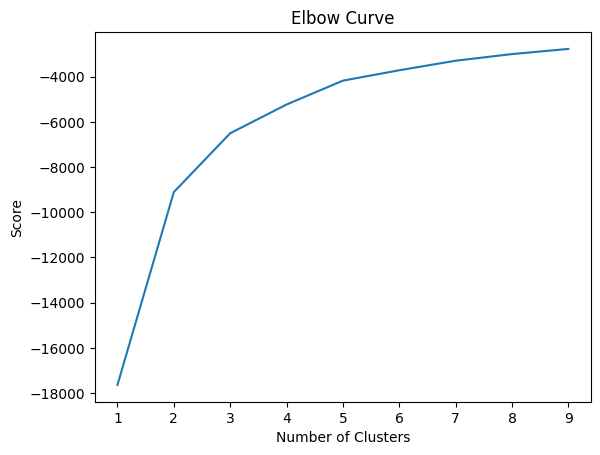

In [77]:
plt.plot(cluster_iteration,scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.xticks(cluster_iteration)
plt.style.use('ggplot')
plt.show()

#### Inference
- From the Elbow Curve, we found that optimal **number of clusters (n_clusters) is 5**

#### Method-2: Using `.inertia_` method (Within-Cluster Sum of Sqaures)

In [78]:
from sklearn.cluster import KMeans

cluster_iteration = range(1,10)
inertias = []

for cluster_number in cluster_iteration:
    K_Means = KMeans(n_clusters=cluster_number, random_state=45)
    K_Means.fit(rfm_normalized)
    inertias.append(K_Means.inertia_)

#### Elbow Curve (Number of Clusters Vs Inertia)

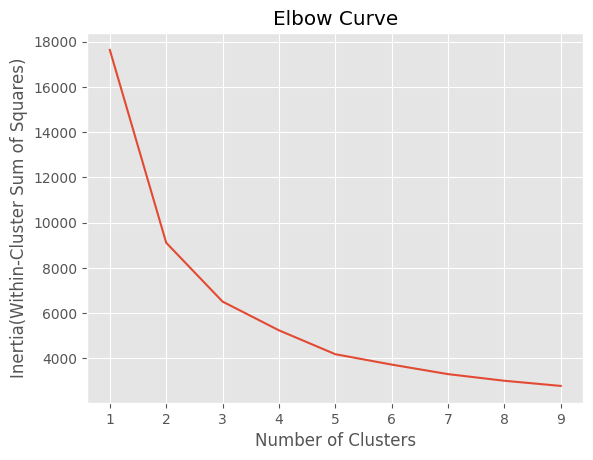

In [79]:
plt.plot(cluster_iteration,inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia(Within-Cluster Sum of Squares)')
plt.title('Elbow Curve')
plt.xticks(cluster_iteration)
plt.style.use('ggplot')
plt.show()

#### Inference
- From the Elbow Curve, we found that optimal **number of clusters (n_clusters) is 5**

### Silhouette Score Method

$$\text{Silhouette Score} = \frac{p - q}{\max(p, q)}$$

- **`p`** is the average distance from the data point to other data points in the same cluster (intra-cluster distance)

- **`q`** is is the smallest average distance from the data point to data points in a different cluster, minimized over clusters (inter-cluster distance).

The value of the silhouette score range lies between **-1 to 1**. 

    - A high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
    - A score near 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters.
    - A low score indicates that the object may have been assigned to the wrong cluster.

In [80]:
from sklearn.cluster import KMeans

cluster_iteration = range(2,10)  # Start from at least 2 clusters (Silhouette Score Requirement)
inertias = []

for cluster_number in cluster_iteration:
    K_Means = KMeans(n_clusters=cluster_number, random_state=45)
    K_Means.fit(rfm_normalized)
    clustered_labels = K_Means.labels_
    
    silhouette_avg = silhouette_score(rfm_normalized,clustered_labels)
    print(f'For n_clusters={cluster_number}, the Silhouette score is {silhouette_avg}')

For n_clusters=2, the Silhouette score is 0.4123261308720177
For n_clusters=3, the Silhouette score is 0.365780580504164
For n_clusters=4, the Silhouette score is 0.36338727455806596
For n_clusters=5, the Silhouette score is 0.34481314227766485
For n_clusters=6, the Silhouette score is 0.3125165446014721
For n_clusters=7, the Silhouette score is 0.310116847330462
For n_clusters=8, the Silhouette score is 0.31155065749796657
For n_clusters=9, the Silhouette score is 0.290639337470191


#### Inference

- From Silhouette Score Analysis for different clusters, we found that optimal **number of cluster(n_clusters) is 5**.

**`Note:`** The choice of number of clusters should be based on combination of quantitative metrics like Elbow method, silhouette score and domain specific knnowledge to ensure that the clusters make sense for your specific use case.

### Final Model with number of clusters(n_cluster) = 5

In [81]:
# Clustering for final model
K_Means_final_model = KMeans(n_clusters= 5, random_state=45)
K_Means_final_model.fit(rfm_normalized)

KMeans(n_clusters=5, random_state=45)

In [82]:
#Create a cluster label column in the original DataFrame
cluster_labels = K_Means_final_model.labels_

In [83]:
cluster_labels

array([4, 4, 0, ..., 1, 3, 4], dtype=int32)

In [84]:
rfm['Cluster'] = cluster_labels

In [85]:
rfm.head()

,Customer ID,Monetary,Frequency,Recency,Cluster
0,12346.0,77556.46,34,325,4
1,12347.0,5633.32,253,1,4
2,12348.0,2019.40,51,74,0
3,12349.0,4428.69,175,18,4
4,12350.0,334.40,17,309,2


In [86]:
rfm.groupby('Cluster').agg({'Recency': 'mean',
                            'Frequency': 'mean',
                            'Monetary': ['mean', 'count'],}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          66.0      87.0   1427.0  1754
1         537.0      13.0    252.0   873
2         115.0      17.0    333.0   965
3         412.0      66.0   1141.0  1028
4          46.0     444.0  10752.0  1258

#### Inference
	
- **Cluster_0:**	1259
- **Cluster_1:**	873
- **Cluster_2:**	1752
- **Cluster_3:**	1029
- **Cluster_4:**	965

In [87]:
rfm_scores['Cluster'] = cluster_labels

In [88]:
rfm_scores

,Customer ID,Monetary,Frequency,Recency,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score_Segment,RFM_Score_Sum,Segment Name,Segment,Segment_New,Cluster
0,12346.0,77556.46,34,325,2,2,5,225,9,Sliver,Hibernating,Big Spenders,4
1,12347.0,5633.32,253,1,5,5,5,555,15,Gold,Champions,Best Customers,4
2,12348.0,2019.40,51,74,3,3,4,334,10,Gold,Need Attention,Big Spenders,0
3,12349.0,4428.69,175,18,5,4,5,545,14,Gold,Champions,Best Customers,4
4,12350.0,334.40,17,309,2,2,2,222,6,Sliver,Hibernating,Almost Lost,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,18283.0,2736.65,986,3,5,5,4,554,14,Gold,Champions,Best Customers,4
5874,18284.0,461.68,28,431,1,2,2,122,5,Bronze,Hibernating,Lost Customers,3
5875,18285.0,427.00,12,660,1,1,2,112,4,Bronze,Hibernating,Lost Customers,1
5876,18286.0,1296.43,67,476,1,3,4,134,8,Sliver,At Risk,Big Spenders,3


<Figure size 1000x600 with 0 Axes>

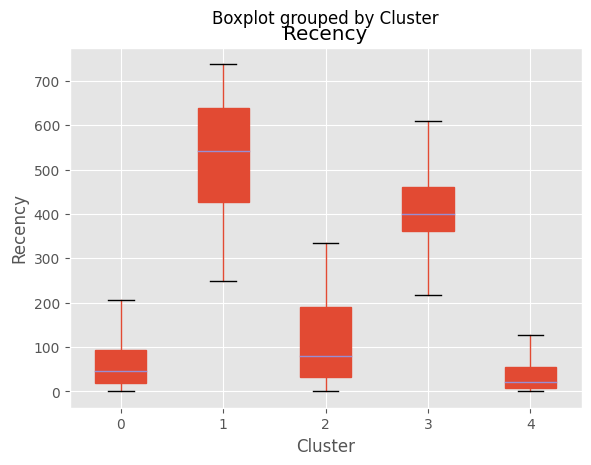

In [89]:
plt.figure(figsize=(10, 6))
rfm_scores.boxplot(column='Recency', by='Cluster', patch_artist=True, showfliers=False)
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

<Figure size 1000x600 with 0 Axes>

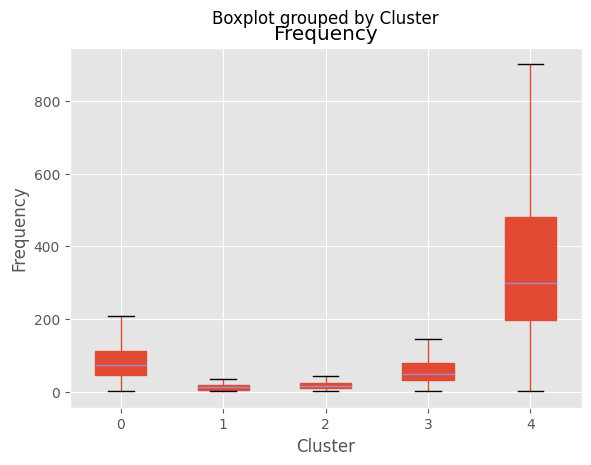

In [90]:
plt.figure(figsize=(10, 6))
rfm_scores.boxplot(column='Frequency', by='Cluster', patch_artist=True, showfliers=False)
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

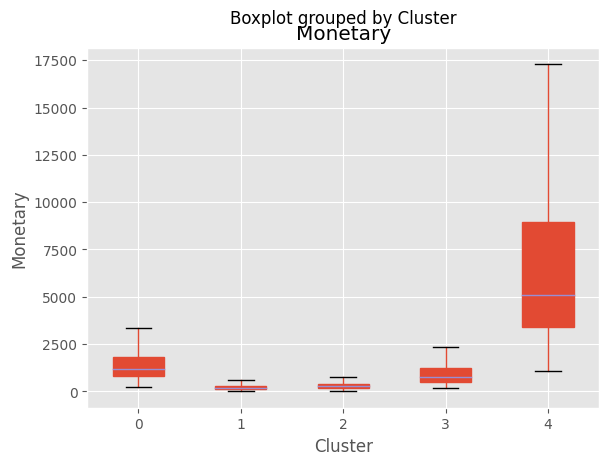

In [91]:
plt.figure(figsize=(10, 6))
rfm_scores.boxplot(column='Monetary', by='Cluster', patch_artist=True, showfliers=False)
plt.xlabel('Cluster')
plt.ylabel('Monetary')
plt.show()